In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from joblib import parallel_backend  # Ensures multiprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [27]:
# Load processed data
sub1_df = pd.read_csv("data/processed_sub1.csv")
sub2_df = pd.read_csv("data/processed_sub2.csv")
sub3_df = pd.read_csv("data/processed_sub3.csv")
sub4_df = pd.read_csv("data/processed_sub4.csv")


In [ ]:
# Features (everything except Sleep_Stage)
X_train = sub1_df.drop(columns=["Sleep_Stage"])
y_train = sub1_df["Sleep_Stage"]

X_test = sub2_df.drop(columns=["Sleep_Stage"])
y_test = sub2_df["Sleep_Stage"]

two_subj_clf = RandomForestClassifier()  # Example classifier
two_subj_clf.fit(X_train, y_train)  # Train on Subject 1

# Predict on Subject 2
y_pred = two_subj_clf.predict(X_test)
two_subj_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy on Subject 2: {two_subj_accuracy:.4f}")


Test Accuracy on Subject 2: 0.5790


In [ ]:

# Combine all subjects
all_data = pd.concat([sub1_df, sub2_df, sub3_df, sub4_df], ignore_index=True)
X = all_data.drop(columns=["Sleep_Stage"])
y = all_data["Sleep_Stage"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees (default is 100)
    max_depth=15,  # Limits tree depth (prevents overfitting & speeds up)
    n_jobs=-1,  # Uses **all 32 CPU cores**
    verbose=1  # Shows progress during training
)

clf.fit(X_train, y_train)

# Test model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy (Random Split 80/20): {accuracy:.4f}")




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s


Test Accuracy (Random Split 80/20): 0.9867


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


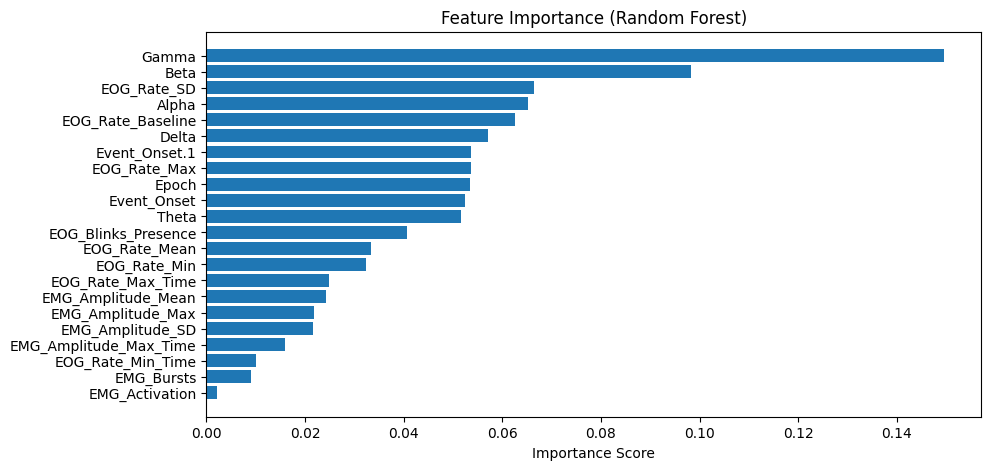

In [ ]:
# Get feature importance
feature_importances = clf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.show()


In [28]:
# Combine all subjects
all_data = pd.concat([sub1_df, sub2_df, sub3_df, sub4_df], ignore_index=True)
X = all_data.drop(columns=["Sleep_Stage"])
y = all_data["Sleep_Stage"]

# Define subject groups for LOSO
groups = np.concatenate([
    np.full(len(sub1_df), 1),  # Subject 1
    np.full(len(sub2_df), 2),  # Subject 2
    np.full(len(sub3_df), 3),  # Subject 3
    np.full(len(sub4_df), 4)   # Subject 4
])

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

# Store accuracies for each fold
cv_accuracies = []

# Loop over each subject as the test set
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Define the classifier with speed optimizations
    clf = RandomForestClassifier(
        n_estimators=50,  # Fewer trees = faster
        max_depth=10,  # Prevents excessive overfitting
        min_samples_leaf=5,  # Ensures splits are meaningful
        n_jobs=-1,  # Use all CPU cores
        verbose=1  # Show training progress
    )

    # Force multiprocessing for speed
    with parallel_backend('loky'):
        clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv_accuracies.append(accuracy)

    print(f"Test Subject: {groups[test_idx][0]}, Accuracy: {accuracy:.4f}")

# Compute the average accuracy across folds
mean_cv_accuracy = np.mean(cv_accuracies)
print(f"\n🚀 LOSO Cross-Validation Accuracy: {mean_cv_accuracy:.4f}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.3s finished


Test Subject: 1, Accuracy: 0.5000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.1s finished


Test Subject: 2, Accuracy: 0.6859


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.9s finished


Test Subject: 3, Accuracy: 0.7370


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.6s


Test Subject: 4, Accuracy: 0.5855

🚀 LOSO Cross-Validation Accuracy: 0.6271


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.2s finished


In [32]:
# Combine all subjects
all_data = pd.concat([sub1_df, sub2_df, sub3_df, sub4_df], ignore_index=True)
X = all_data.drop(columns=["Sleep_Stage"])
y = all_data["Sleep_Stage"]

# Define subject groups for LOSO (before oversampling)
original_groups = np.concatenate([
    np.full(len(sub1_df), 1),  # Subject 1
    np.full(len(sub2_df), 2),  # Subject 2
    np.full(len(sub3_df), 3),  # Subject 3
    np.full(len(sub4_df), 4)   # Subject 4
])

### **1️⃣ Normalize Features Across Subjects**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize all features

### **2️⃣ Balance Classes (Avoid Overpredicting N2)**
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_scaled, y)

# **3️⃣ Regenerate groups after oversampling**
# Since oversampling creates new synthetic samples, we need to assign new groups
# We'll randomly distribute the new samples based on original proportions
num_extra_samples = len(X_balanced) - len(X)  # How many new samples were created?
extra_groups = np.random.choice(original_groups, size=num_extra_samples, replace=True)

# Concatenate the original and new group labels
groups_balanced = np.concatenate([original_groups, extra_groups])

# Ensure lengths now match
assert len(X_balanced) == len(y_balanced) == len(groups_balanced), "Mismatch in data lengths!"

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()
cv_accuracies = []

# Loop over each subject as the test set
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups_balanced):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]

    # Define the classifier with optimizations
    clf = RandomForestClassifier(
        n_estimators=50,  # Fewer trees for speed
        max_depth=10,  # Prevents excessive overfitting
        min_samples_leaf=5,  # Ensures splits are meaningful
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )

    # Force multiprocessing for speed
    with parallel_backend('loky'):
        clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv_accuracies.append(accuracy)

    print(f"Test Subject: {groups_balanced[test_idx][0]}, Accuracy: {accuracy:.4f}")

# Compute the average accuracy across folds
mean_cv_accuracy = np.mean(cv_accuracies)
print(f"\n🚀 LOSO Cross-Validation Accuracy (After Scaling & Balancing): {mean_cv_accuracy:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    8.1s finished


Test Subject: 1, Accuracy: 0.9059


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    8.0s finished


Test Subject: 2, Accuracy: 0.9023


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    8.3s finished


Test Subject: 3, Accuracy: 0.9001


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    8.6s finished


Test Subject: 4, Accuracy: 0.8813

🚀 LOSO Cross-Validation Accuracy (After Scaling & Balancing): 0.8974
